In [1]:
from SALib.analyze.sobol import analyze
from SALib.sample.sobol import sample

from adsorption_model import ThomasModel, ThomasExperimentalSetup
import numpy as np

from multiprocessing import Pool
import matplotlib.pyplot as plt

In [2]:
setup = ThomasExperimentalSetup(
    C_0=2.07,  # µg/L
    length=1.13,  # cm
    rho_p=1100,  # g/L
    pore_velocity=1714.9,  # cm/h
    porosity=0.4,  # -
)

t = np.arange(0.1, 40.1, 0.1)


def wrapped_thomas(X):
    return ThomasModel(t, *X, **setup)

In [3]:
# Define the model inputs
names = ["$k_T$", "$q_m$", "$b$"]

problem = {
    "num_vars": len(names),
    "names": names,
    "bounds": [
        [0.01, 1],
        [0, 100],
        [0.1, 100],
    ],
}

In [4]:
# Generate samples
param_values = sample(problem, 2048, seed=1)
param_values

array([[ 0.16391066, 58.87473263, 60.79246431],
       [ 0.24997599, 58.87473263, 60.79246431],
       [ 0.16391066, 84.56894653, 60.79246431],
       ...,
       [ 0.45939665, 40.64026317, 78.44334706],
       [ 0.45939665, 31.23253193,  3.42509813],
       [ 0.45939665, 31.23253193, 78.44334706]])

In [5]:
# Run model (example)
with Pool() as pool:
    Y = pool.map(wrapped_thomas, param_values)

In [6]:
# Perform analysis
ndY = np.array(Y).T


def partial_analyze(y):
    return analyze(problem=problem, Y=y, print_to_console=False)


with Pool() as pool:
    Si = pool.map(partial_analyze, ndY)

In [7]:
fo_names = problem["names"]
first_order = np.array([s["S1"] for s in Si]).T
fo_confidence = np.array([s["S1_conf"] for s in Si]).T

so_names = [
    f"{fo_names[0]}, {fo_names[1]}",
    f"{fo_names[0]}, {fo_names[2]}",
    f"{fo_names[1]}, {fo_names[2]}",
]
second_order = np.array(
    [
        [s["S2"][0, 1] for s in Si],
        [s["S2"][0, 2] for s in Si],
        [s["S2"][1, 2] for s in Si],
    ]
)
so_confidence = np.array(
    [
        [s["S2_conf"][0, 1] for s in Si],
        [s["S2_conf"][0, 2] for s in Si],
        [s["S2_conf"][1, 2] for s in Si],
    ]
)

tot_names = fo_names
tot_order = np.array([s["ST"] for s in Si]).T
tot_confidence = np.array([s["ST_conf"] for s in Si]).T

In [8]:
tot_order.T[-1]

array([0.03611686, 0.99077534, 0.03660248])

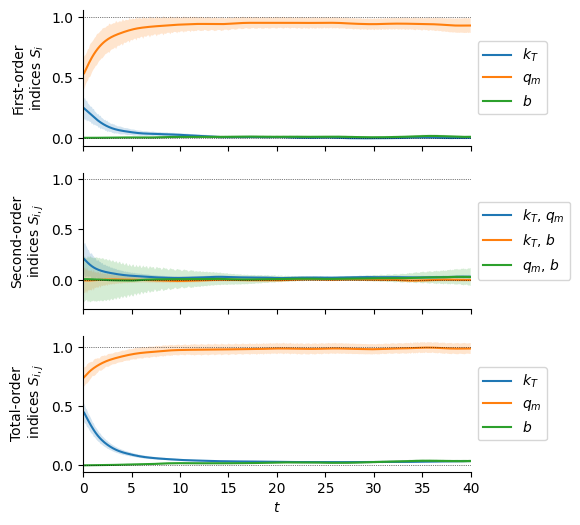

In [9]:
fig, axs = plt.subplots(
    3,
    1,
    sharex="col",
    sharey="row",
    figsize=(5, 6),
)

ax = axs[0]
for name, si, conf in zip(fo_names, first_order, fo_confidence):
    ax.plot(t, si, label=name)
    ax.fill_between(t, si - conf, si + conf, alpha=0.2)
    ax.set_ylabel("First-order\nindices $S_i$")


ax = axs[1]
for name, si, conf in zip(so_names, second_order, so_confidence):
    ax.plot(t, si, label=name)
    ax.fill_between(t, si - conf, si + conf, alpha=0.2)
    ax.set_ylabel("Second-order\nindices $S_{i,j}$")

ax = axs[2]
for name, si, conf in zip(tot_names, tot_order, tot_confidence):
    ax.plot(t, si, label=name)
    ax.fill_between(t, si - conf, si + conf, alpha=0.2)
    ax.set_ylabel("Total-order\n indices $S_{i,j}$")

ax.set_xlabel("$t$")
ax.set_xlim(0, 40)

for ax in axs.flatten():
    ax.axhline(1, color="gray", ls="dotted", lw=0.5, c="k")
    ax.axhline(0, color="gray", ls="dotted", lw=0.5, c="k")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)

plt.show()

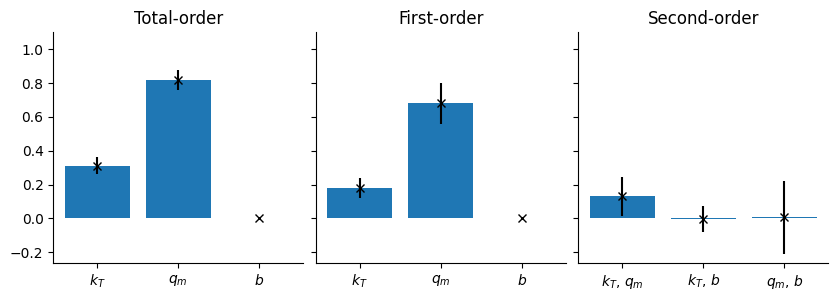

In [11]:
t_select = 1
tidx = np.argmin(np.abs(t - t_select))

fig, axs = plt.subplots(
    1, 3, figsize=(10, 3), sharey=True, gridspec_kw={"wspace": 0.05}
)

ax = axs[0]
dummy_x = np.arange(len(tot_names))
ax.bar(dummy_x, tot_order.T[tidx])
ax.errorbar(
    dummy_x,
    tot_order.T[tidx],
    yerr=tot_confidence.T[tidx],
    fmt="x",
    color="k",
)
ax.set_xticks(dummy_x)
ax.set_xticklabels(tot_names)
ax.set_title("Total-order")

ax = axs[1]
dummy_x = np.arange(len(fo_names))
ax.bar(dummy_x, first_order.T[tidx])
ax.errorbar(
    dummy_x,
    first_order.T[tidx],
    yerr=fo_confidence.T[tidx],
    fmt="x",
    color="k",
)
ax.set_xticks(dummy_x)
ax.set_xticklabels(fo_names)
ax.set_title("First-order")

ax = axs[2]
dummy_x = np.arange(len(so_names))
ax.bar(dummy_x, second_order.T[tidx])
ax.errorbar(
    dummy_x,
    second_order.T[tidx],
    yerr=so_confidence.T[tidx],
    fmt="x",
    color="k",
)
ax.set_xticks(dummy_x)
ax.set_xticklabels(so_names)
ax.set_title("Second-order")

for ax in axs:
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.set_ylim(top=1.1)

plt.show()